# Description
Scoring peptides to a weight matrix

## Python Imports

In [1]:
import numpy as np
from pprint import pprint

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

%matplotlib inline

## DEFINE THE PATH TO YOUR COURSE DATA DIRECTORY

In [2]:
data_dir = "/Users/alberteenglund/Documents/DTU/8_Semester/22125_algorithms_in_bioinformatics/algorithms/data/"

## Initialize Matrix

In [3]:
def initialize_matrix(peptide_length, alphabet):

    init_matrix = [0]*peptide_length

    for i in range(0, peptide_length):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix

### Load Matrix from PSI-BLAST format

In [4]:
def from_psi_blast(file_name):

    f = open(file_name, "r")
    
    nline = 0
    for line in f:
    
        sline = str.split( line )
        
        if nline == 0:
        # recover alphabet
            alphabet = [str]*len(sline)
            for i in range(0, len(sline)):
                alphabet[i] = sline[i]
                
            matrix = initialize_matrix(peptide_length, alphabet)
        
        else:
            i = int(sline[0])
            
            for j in range(2,len(sline)):
                matrix[i-1][alphabet[j-2]] = float(sline[j])
                
        nline+= 1
            
    return matrix

### Score peptide to mat

In [6]:
def score_peptide(peptide, matrix):
    acum = 0
    for i in range(0, len(peptide)):
        acum += matrix[i][peptide[i]]
    return acum

## Main

ILYQVPFSV 0.7369000000000004 0.8532
VVMGTLVAL 2.2598000000000003 0.5891
ILDEAYVMA 1.5876000000000008 0.4941
KILSVFFLA -8.0336 0.8512
HLYQGCQVV 1.2188000000000003 0.5386
YLDLALMSV 1.2593 0.8425
ALAKAAAAA 31.014 0.5631
MALLRLPLV -10.9095 0.6337
FLLTRILTI -3.8073000000000006 0.8027
ILSSLGLPV 0.6170000000000003 0.6384
RMYGVLPWI -6.6517 0.6889
ALPYWNFAT 2.0772999999999997 0.3233
YLEPGPVTV 0.10060000000000013 0.6472
FLPWHRLFL -6.679599999999999 0.5637
LLPSLFLLL -3.2786 0.5537
MLQDMAILT 0.6822999999999996 0.5269
LVSLLTFMI -5.6023 0.3011
GLMTAVYLV 3.4934000000000003 0.798
ILTVILGVL -0.6420999999999992 0.4507
GLYSSTVPV 2.8985000000000003 0.6972
SLYFGGICV -0.6673999999999999 0.7819
GLYYLTTEV -1.2561999999999998 0.7195
ALYGALLLA 3.007299999999999 0.8176
IMPGQEAGL 2.7672999999999996 0.6144
WLSLLVPFV -3.922399999999999 0.8221
YLVAYQATV 3.1799 0.6391
RLMIGTAAA 5.700200000000001 0.4986
WLDQVPFSV -0.47270000000000023 0.7742
AAAKAAAAV 27.387 0.4463
KTWGQYWQV -11.3078 0.778
VIHAFQYVI -4.874000000000001 

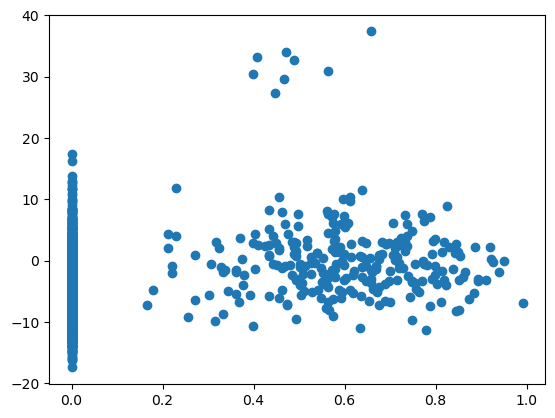

In [9]:
# Read evaluation data
#evaluation_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_2/A0201.eval"
evaluation_file = data_dir + "PSSM/A0201.eval"

evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,2)
evaluation_peptides = evaluation[:, 0]
evaluation_targets = evaluation[:, 1].astype(float)

evaluation_peptides, evaluation_targets

peptide_length = len(evaluation_peptides[0])

# Define which PSSM file to use (file save from pep2mat)
pssm_file = data_dir + "PSSM/A0201.single_lig_mat"

w_matrix = from_psi_blast(pssm_file)

evaluation_predictions = []
for i in range(len(evaluation_peptides)):
    score = score_peptide(evaluation_peptides[i], w_matrix)
    evaluation_predictions.append(score)
    print (evaluation_peptides[i], score, evaluation_targets[i])
    
pcc = pearsonr(evaluation_targets, evaluation_predictions)
print("PCC: ", pcc[0])

plt.scatter(evaluation_targets, evaluation_predictions);
